<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

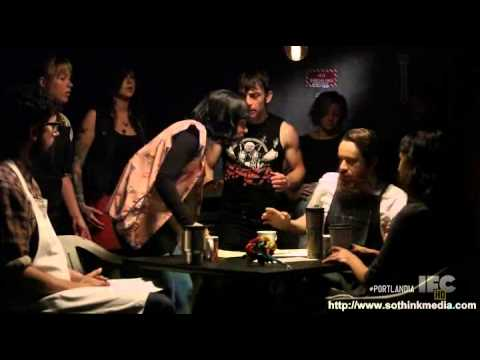

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [2]:
%pwd

'/Users/ericchiyembekeza/Desktop/Lambda School/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [3]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [4]:
import numpy as np

In [5]:
from collections import Counter
import re

#NLP Libs
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

shops.shape

(7616, 3)

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [9]:
#Create cols

shops['star_rating'] = shops['star_rating'].apply(lambda x: x[:4])
shops['date'] = shops['full_review_text'].apply(lambda x: x.split()[:1])

In [10]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0,[11/25/2016]
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0,[12/2/2016]
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0,[11/30/2016]
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0,[11/25/2016]
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0,[12/3/2016]


In [11]:
shops['star_rating'] = shops['star_rating'].apply(lambda x: float(x))
shops['date'] = shops['date'].apply(lambda x: pd.to_datetime(x[0]))

In [12]:
shops['full_review_text'] = shops['full_review_text'].apply(lambda x: re.sub(r'[^a-zA-Z ]', '', x))

In [13]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,date
0,The Factory - Cafe With a Soul,checkin Love love loved the atmosphere Ever...,5.0,2016-11-25
1,The Factory - Cafe With a Soul,Listed in Date Night Austin Ambiance in Aust...,4.0,2016-12-02
2,The Factory - Cafe With a Soul,checkin Listed in Brunch Spots I loved the ...,4.0,2016-11-30
3,The Factory - Cafe With a Soul,Very cool decor Good drinks Nice seating Ho...,2.0,2016-11-25
4,The Factory - Cafe With a Soul,checkin They are located within the Northcr...,4.0,2016-12-03


In [14]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7616 entries, 0 to 7615
Data columns (total 4 columns):
coffee_shop_name    7616 non-null object
full_review_text    7616 non-null object
star_rating         7616 non-null float64
date                7616 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 238.1+ KB


In [15]:
shops['rating'] = ['bad' if x < 4 else 'good' for x in shops['star_rating']]

In [16]:
shops.head()

,coffee_shop_name,full_review_text,star_rating,date,rating
0,The Factory - Cafe With a Soul,checkin Love love loved the atmosphere Ever...,5.0,2016-11-25,good
1,The Factory - Cafe With a Soul,Listed in Date Night Austin Ambiance in Aust...,4.0,2016-12-02,good
2,The Factory - Cafe With a Soul,checkin Listed in Brunch Spots I loved the ...,4.0,2016-11-30,good
3,The Factory - Cafe With a Soul,Very cool decor Good drinks Nice seating Ho...,2.0,2016-11-25,bad
4,The Factory - Cafe With a Soul,checkin They are located within the Northcr...,4.0,2016-12-03,good


In [17]:
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [18]:
STOP_WORDS = nlp.Defaults.stop_words.union([
    ' ',
    '  ',
    '   ',
    'like', 
    'checkin', 
    'im', 
    'ive',
    'got',
    'come',
    'coffee',
    'place'
])

In [19]:
# create tokens from reviews text
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.lemma_.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [20]:
# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 25 most common words
word_counts.most_common(25)

[('good', 4150),
 ('great', 3944),
 ('time', 2377),
 ('drink', 2318),
 ('love', 2298),
 ('austin', 2252),
 ('shop', 2216),
 ('order', 2105),
 ('try', 2083),
 ('food', 1890),
 ('work', 1877),
 ('latte', 1852),
 ('nice', 1794),
 ('well', 1701),
 ('friendly', 1688),
 ('little', 1504),
 ('tea', 1482),
 ('seat', 1451),
 ('people', 1437),
 ('delicious', 1402),
 ('service', 1381),
 ('pretty', 1366),
 ('ice', 1363),
 ('go', 1356),
 ('staff', 1307)]

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [21]:
# create dfs of good shops and bad shops
good_shops = shops[shops['rating'] == 'good']
bad_shops = shops[shops['rating'] == 'bad']

# make sure length of good and bad dfs equal combined df
assert len(good_shops) + len(bad_shops) == len(shops)

In [22]:
good_shops.head()

,coffee_shop_name,full_review_text,star_rating,date,rating,tokens
0,The Factory - Cafe With a Soul,checkin Love love loved the atmosphere Ever...,5.0,2016-11-25,good,"[love, love, love, atmosphere, corner, shop, s..."
1,The Factory - Cafe With a Soul,Listed in Date Night Austin Ambiance in Aust...,4.0,2016-12-02,good,"[listed, date, night, austin, ambiance, austin..."
2,The Factory - Cafe With a Soul,checkin Listed in Brunch Spots I loved the ...,4.0,2016-11-30,good,"[listed, brunch, spots, love, eclectic, homey,..."
4,The Factory - Cafe With a Soul,checkin They are located within the Northcr...,4.0,2016-12-03,good,"[locate, northcross, mall, shop, center, face,..."
5,The Factory - Cafe With a Soul,checkin Very cute cafe I think from the mom...,4.0,2016-11-20,good,"[cute, cafe, think, moment, step, wasnt, didnt..."


In [23]:
bad_shops.head()

,coffee_shop_name,full_review_text,star_rating,date,rating,tokens
3,The Factory - Cafe With a Soul,Very cool decor Good drinks Nice seating Ho...,2.0,2016-11-25,bad,"[cool, decor, good, drink, nice, seat, overpri..."
8,The Factory - Cafe With a Soul,checkin Ok lets try this approach Pros Mus...,3.0,2016-10-25,bad,"[ok, let, try, approach, pros, music, seating,..."
11,The Factory - Cafe With a Soul,The store has A decoration but honestly the ...,3.0,2016-11-20,bad,"[store, decoration, honestly, good, shop, surr..."
12,The Factory - Cafe With a Soul,checkin Listed in The Third Time is a Cha...,3.0,2016-11-17,bad,"[listed, time, charm, factory, decor, innovati..."
25,The Factory - Cafe With a Soul,Okay so after visiting my friends in LA and ...,1.0,2016-12-02,bad,"[okay, visit, friend, la, try, mint, mojito, i..."


In [24]:
good_shops['tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(15)

[('great', 7416),
 ('good', 7391),
 ('love', 4342),
 ('austin', 4221),
 ('time', 4141),
 ('drink', 4041),
 ('shop', 4004),
 ('try', 3749),
 ('order', 3462),
 ('latte', 3377),
 ('work', 3353),
 ('food', 3286),
 ('nice', 3229),
 ('friendly', 3175),
 ('well', 3086)]

In [25]:
bad_shops['tokens'].apply(lambda x: word_counts.update(x))
word_counts.most_common(15)

[('good', 8300),
 ('great', 7888),
 ('time', 4754),
 ('drink', 4636),
 ('love', 4596),
 ('austin', 4504),
 ('shop', 4432),
 ('order', 4210),
 ('try', 4166),
 ('food', 3780),
 ('work', 3754),
 ('latte', 3704),
 ('nice', 3588),
 ('well', 3402),
 ('friendly', 3376)]

In [26]:
# functon to count words, appears in, rank, percent total, etc.
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = map(list, zip(word_counts.keys(), word_counts.values()))
        
        wc = pd.DataFrame(temp, columns=['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [27]:
wc = count(shops['tokens'])
wc_good = count(good_shops['tokens'])
wc_bad = count(bad_shops['tokens'])

In [28]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
142,good,2881,4150,1.0,0.012418,0.012418,0.378283
86,great,2852,3944,2.0,0.011802,0.024221,0.374475
448,time,1752,2377,3.0,0.007113,0.031334,0.230042
3,drink,1621,2318,4.0,0.006936,0.038270,0.212841
36,love,1759,2298,5.0,0.006877,0.045146,0.230961


In [29]:
wc_good.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
86,great,2504,3472,1.0,0.013315,0.013315,0.407818
171,good,2277,3241,2.0,0.012429,0.025744,0.370847
36,love,1549,2044,3.0,0.007839,0.033583,0.252280
54,austin,1547,1969,4.0,0.007551,0.041134,0.251954
0,shop,1334,1788,5.0,0.006857,0.047991,0.217264


In [30]:
wc_bad.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
10,good,604,909,1.0,0.012380,0.012380,0.409214
114,order,422,748,2.0,0.010188,0.022568,0.285908
179,time,422,613,3.0,0.008349,0.030917,0.285908
3,drink,353,595,4.0,0.008104,0.039020,0.239160
119,food,316,494,5.0,0.006728,0.045749,0.214092


In [31]:
words = wc['word']
good = wc_good[['word', 'pct_total']]
bad = wc_bad[['word', 'pct_total']]

In [32]:
words.shape

(16418,)

In [47]:
good.shape, bad.shape

((14214, 2), (7256, 2))

In [48]:
result = pd.merge(words, good, on='word', how='outer')

In [51]:
result = pd.merge(result, bad, on='word', how='outer')

In [52]:
result

,word,pct_total_x,pct_total_y
0,good,0.012380,0.012380
1,great,0.006429,0.006429
2,time,0.008349,0.008349
3,drink,0.008104,0.008104
4,love,0.003459,0.003459
5,austin,0.003854,0.003854
6,shop,0.005829,0.005829
7,order,0.010188,0.010188
8,try,0.005679,0.005679
9,food,0.006728,0.006728


In [53]:
result = result.rename(columns={"pct_total_x": "pct_good", "pct_total_y": "pct_bad"})

In [56]:
result['difference'] = (result['pct_good']-result['pct_bad'])

In [57]:
result['more_in'] = np.where(result['pct_good']>result['pct_bad'], 'good', 'bad')

In [58]:
result.head()

,word,pct_good,pct_bad,difference,more_in
0,good,0.012380,0.012380,0.0,bad
1,great,0.006429,0.006429,0.0,bad
2,time,0.008349,0.008349,0.0,bad
3,drink,0.008104,0.008104,0.0,bad
4,love,0.003459,0.003459,0.0,bad


## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

